In [1]:
import torch
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GNNExplainer, PGExplainer, GraphLIME, IntegratedGradExplainer, SubgraphX, PGMExplainer
from graphxai.metrics import graph_exp_acc, graph_exp_faith
# from graphxai.visualization import ExplanationVisualizer
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, GATv2Conv, SAGEConv, global_mean_pool, global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        
        return self.lin(x)


class GIN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_dim, hidden_dim))
        self.conv2 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)
        
        return self.lin(x)
    

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.5):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.conv3 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        
        x = global_max_pool(x, batch)

        return self.lin(x)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggr='mean')
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.conv3 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)

        return self.lin(x)


In [3]:
in_dim = 5
hidden_dim = 32
out_dim = 2

models = {
    'GIN': GIN(in_dim, hidden_dim, out_dim).to(device),
    'GCN': GCN(in_dim, hidden_dim, out_dim).to(device),
    'GAT': GAT(in_dim, hidden_dim, out_dim).to(device),
    'GraphSAGE': GraphSAGE(in_dim, hidden_dim, out_dim).to(device)
}

In [4]:
from TreeDataset import TreeDataset

dataset = TreeDataset(device=device)
batch_size = 16
train_loader = dataset.get_train_loader(batch_size=batch_size)[0]
val_loader = dataset.get_val_loader()[0]
test_loader = dataset.get_test_loader()[0]

tensor([1], device='cuda:0')
Data(x=[12, 5], edge_index=[2, 11], y=[1], exp_key=[1])


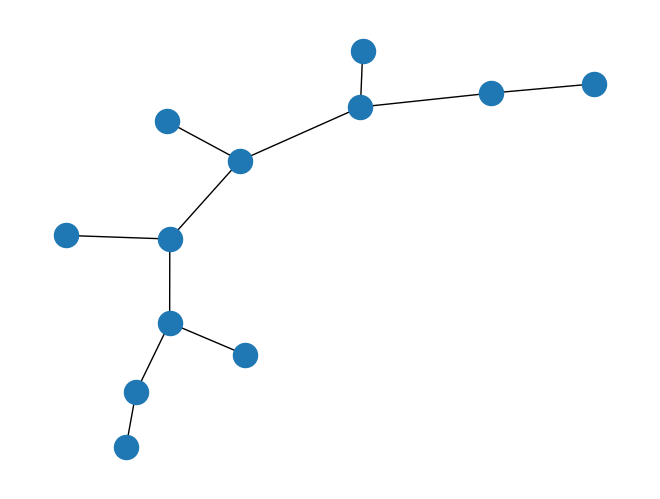

In [53]:
import networkx as nx

test_graph = dataset.get_test_w_label(1)[0]
# ind = 686
print(test_graph.y)
print(test_graph)
nx.draw(nx.Graph(test_graph.edge_index.T.tolist()))
# dataset.graphs[0].edge_index.T.tolist()

In [54]:
for i in val_loader.dataset:
    if i.edge_index.shape[0] == 0:
        test_graph = i

In [17]:
torch.cuda.empty_cache()

In [5]:
from graphxai.gnn_models.graph_classification import train, test


for model_name, model in models.items():
    print("\n\t" + model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    for epoch in range(30):
        train(model, optimizer, criterion, train_loader)
        f1, _, _, _, auc = test(model, val_loader)

        print(f'epoch: {epoch+1:1d}, val F1: {f1:.4f}, val AUC: {auc:.4f}')

    f1, _, _, _, auc = test(model, test_loader)
    print(f'test F1: {f1:.4f}, test AUC: {auc:.4f}')


	GIN
epoch: 1, val F1: 0.1633, val AUC: 0.9157
epoch: 2, val F1: 0.7389, val AUC: 0.9078
epoch: 3, val F1: 0.8230, val AUC: 0.9060
epoch: 4, val F1: 0.8469, val AUC: 0.9077
epoch: 5, val F1: 0.7805, val AUC: 0.9145
epoch: 6, val F1: 0.8556, val AUC: 0.9244
epoch: 7, val F1: 0.8705, val AUC: 0.9184
epoch: 8, val F1: 0.8646, val AUC: 0.9200
epoch: 9, val F1: 0.8710, val AUC: 0.9284
epoch: 10, val F1: 0.8602, val AUC: 0.9281
epoch: 11, val F1: 0.8571, val AUC: 0.9303
epoch: 12, val F1: 0.8788, val AUC: 0.9348
epoch: 13, val F1: 0.8840, val AUC: 0.9372
epoch: 14, val F1: 0.8889, val AUC: 0.9404
epoch: 15, val F1: 0.8877, val AUC: 0.9388
epoch: 16, val F1: 0.8744, val AUC: 0.9391
epoch: 17, val F1: 0.8832, val AUC: 0.9351
epoch: 18, val F1: 0.8776, val AUC: 0.9449
epoch: 19, val F1: 0.9016, val AUC: 0.9443
epoch: 20, val F1: 0.8901, val AUC: 0.9450
epoch: 21, val F1: 0.9140, val AUC: 0.9509
epoch: 22, val F1: 0.9206, val AUC: 0.9502
epoch: 23, val F1: 0.9206, val AUC: 0.9496
epoch: 24, val

d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 1, val F1: 0.0000, val AUC: 0.8658


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 2, val F1: 0.0000, val AUC: 0.8611


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 3, val F1: 0.0000, val AUC: 0.8657


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 4, val F1: 0.0000, val AUC: 0.8614


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 5, val F1: 0.0000, val AUC: 0.8395


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 6, val F1: 0.0000, val AUC: 0.8443


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 7, val F1: 0.0000, val AUC: 0.8459


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 8, val F1: 0.0000, val AUC: 0.8300


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 9, val F1: 0.0000, val AUC: 0.8487


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 10, val F1: 0.0000, val AUC: 0.8154


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 11, val F1: 0.0000, val AUC: 0.8185


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 12, val F1: 0.0000, val AUC: 0.8212


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 13, val F1: 0.0000, val AUC: 0.8458


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 14, val F1: 0.0000, val AUC: 0.8222


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 15, val F1: 0.0000, val AUC: 0.8250


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 16, val F1: 0.0000, val AUC: 0.8323


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 17, val F1: 0.0000, val AUC: 0.8080


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 18, val F1: 0.0000, val AUC: 0.8347


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 19, val F1: 0.0000, val AUC: 0.8065


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 20, val F1: 0.0000, val AUC: 0.7958


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 21, val F1: 0.0000, val AUC: 0.7970


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 22, val F1: 0.0000, val AUC: 0.7940


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 23, val F1: 0.0000, val AUC: 0.8134


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 24, val F1: 0.0000, val AUC: 0.7986


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 25, val F1: 0.0000, val AUC: 0.7898


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 26, val F1: 0.0000, val AUC: 0.8221


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 27, val F1: 0.0000, val AUC: 0.8042


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 28, val F1: 0.0000, val AUC: 0.7987


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 29, val F1: 0.0000, val AUC: 0.7305


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 30, val F1: 0.0000, val AUC: 0.7369


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test F1: 0.0000, test AUC: 0.7459

	GraphSAGE
epoch: 1, val F1: 0.8525, val AUC: 0.9383
epoch: 2, val F1: 0.8791, val AUC: 0.9483
epoch: 3, val F1: 0.8877, val AUC: 0.9515
epoch: 4, val F1: 0.8554, val AUC: 0.9507
epoch: 5, val F1: 0.8808, val AUC: 0.9568
epoch: 6, val F1: 0.8914, val AUC: 0.9562
epoch: 7, val F1: 0.8995, val AUC: 0.9575
epoch: 8, val F1: 0.9043, val AUC: 0.9557
epoch: 9, val F1: 0.9050, val AUC: 0.9564
epoch: 10, val F1: 0.8973, val AUC: 0.9578
epoch: 11, val F1: 0.8925, val AUC: 0.9563
epoch: 12, val F1: 0.9040, val AUC: 0.9582
epoch: 13, val F1: 0.9111, val AUC: 0.9592
epoch: 14, val F1: 0.9180, val AUC: 0.9577
epoch: 15, val F1: 0.9130, val AUC: 0.9580
epoch: 16, val F1: 0.9282, val AUC: 0.9549
epoch: 17, val F1: 0.9101, val AUC: 0.9559
epoch: 18, val F1: 0.8837, val AUC: 0.9519
epoch: 19, val F1: 0.9231, val AUC: 0.9538
epoch: 20, val F1: 0.9282, val AUC: 0.9527
epoch: 21, val F1: 0.9091, val AUC: 0.9523
epoch: 22, val F1: 0.9341, val AUC: 0.9522
epoch: 23, val F1

In [6]:

for model_name, model in models.items():
    f1, _, _, _, auc = test(model, test_loader)
    print(f"{model_name}: {f1}")

GIN: 0.8992974238875878
GCN: 0.7326732673267327


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GAT: 0.0
GraphSAGE: 0.8861386138613861


In [269]:
test_graph, explanation = dataset.get_test_w_label(0)
test_graph.edge_index

tensor([[ 1,  0,  2,  1,  3,  2,  4,  3,  5,  3,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 11, 14,  9, 15, 14, 16, 15, 17, 16, 18, 16,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22,  5, 10, 19, 23],
        [ 0,  1,  1,  2,  2,  3,  3,  4,  3,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 11, 13,  9, 14, 14, 15, 15, 16, 16, 17, 16, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 10,  5, 23, 19]])

In [62]:
for i in dataset.graphs:
    if i.edge_index.shape[0] == 0:
        print(i)

Data(x=[3, 5], edge_index=[0], y=[1], exp_key=[1])


In [65]:
from graphxai.explainers import PGExplainer, IntegratedGradExplainer, GNNExplainer, SubgraphX, RandomExplainer


null_batch = torch.zeros(1).long().cuda()
forward_kwargs = {'batch': null_batch}

explainers = {model_name: {} for model_name in models}

for idx, (name, model) in enumerate(models.items()):
    in_channels = (64 if name in ["GAT", "GraphSAGE"] else None)
    pgex = PGExplainer(model, emb_layer_name='conv3', in_channels=in_channels, explain_graph=True, max_epochs=5)
    pgex.train_explanation_model(dataset.get_val_list()[0], forward_kwargs=forward_kwargs)

    igex = IntegratedGradExplainer(model, criterion=criterion)
    gnnex = GNNExplainer(model)
    rndex = RandomExplainer(model)
    
    subex = SubgraphX(model)

    explainers[name] = {
        "PGExplainer": pgex,
        "GNNExplainer": gnnex,
        "RandomExplainer": rndex,
        "IntegratedGradExplainer": igex,
        "SubgraphX": subex
    }


100%|██████████| 201/201 [00:02<00:00, 89.74it/s]


Epoch: 0 | Loss: 18.540066862478852


100%|██████████| 201/201 [00:02<00:00, 90.26it/s]


Epoch: 1 | Loss: 15.995425081346184


100%|██████████| 201/201 [00:02<00:00, 83.99it/s]


Epoch: 2 | Loss: 13.976231686305255


100%|██████████| 201/201 [00:02<00:00, 88.15it/s]


Epoch: 3 | Loss: 12.342453503166325


100%|██████████| 201/201 [00:02<00:00, 89.83it/s]


Epoch: 4 | Loss: 10.641405122820288


100%|██████████| 201/201 [00:02<00:00, 91.07it/s]


Epoch: 0 | Loss: 35.816045626066625


100%|██████████| 201/201 [00:02<00:00, 89.53it/s]


Epoch: 1 | Loss: 35.48335988074541


100%|██████████| 201/201 [00:02<00:00, 92.24it/s]


Epoch: 2 | Loss: 34.76184713002294


100%|██████████| 201/201 [00:02<00:00, 90.39it/s]


Epoch: 3 | Loss: 34.073052485473454


100%|██████████| 201/201 [00:02<00:00, 88.21it/s]


Epoch: 4 | Loss: 33.18122176080942


100%|██████████| 201/201 [00:03<00:00, 59.10it/s]


Epoch: 0 | Loss: 24.08785375393927


100%|██████████| 201/201 [00:03<00:00, 57.85it/s]


Epoch: 1 | Loss: 21.56835333071649


100%|██████████| 201/201 [00:03<00:00, 60.58it/s]


Epoch: 2 | Loss: 18.48993401415646


100%|██████████| 201/201 [00:03<00:00, 60.14it/s]


Epoch: 3 | Loss: 14.494059692602605


100%|██████████| 201/201 [00:03<00:00, 58.04it/s]


Epoch: 4 | Loss: 10.177051272708923


100%|██████████| 201/201 [00:02<00:00, 93.77it/s]


Epoch: 0 | Loss: 23.15853786561638


100%|██████████| 201/201 [00:02<00:00, 85.27it/s]


Epoch: 1 | Loss: 22.119472271297127


100%|██████████| 201/201 [00:02<00:00, 90.15it/s]


Epoch: 2 | Loss: 20.761971227359027


100%|██████████| 201/201 [00:02<00:00, 90.27it/s]


Epoch: 3 | Loss: 19.26268856227398


100%|██████████| 201/201 [00:02<00:00, 93.97it/s]

Epoch: 4 | Loss: 17.007935269735754


In [47]:
model.eval()
out = model(test_graph.x, test_graph.edge_index)
pred = out.argmax(dim=1).item()
pred

0

d:\Apps\Python\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


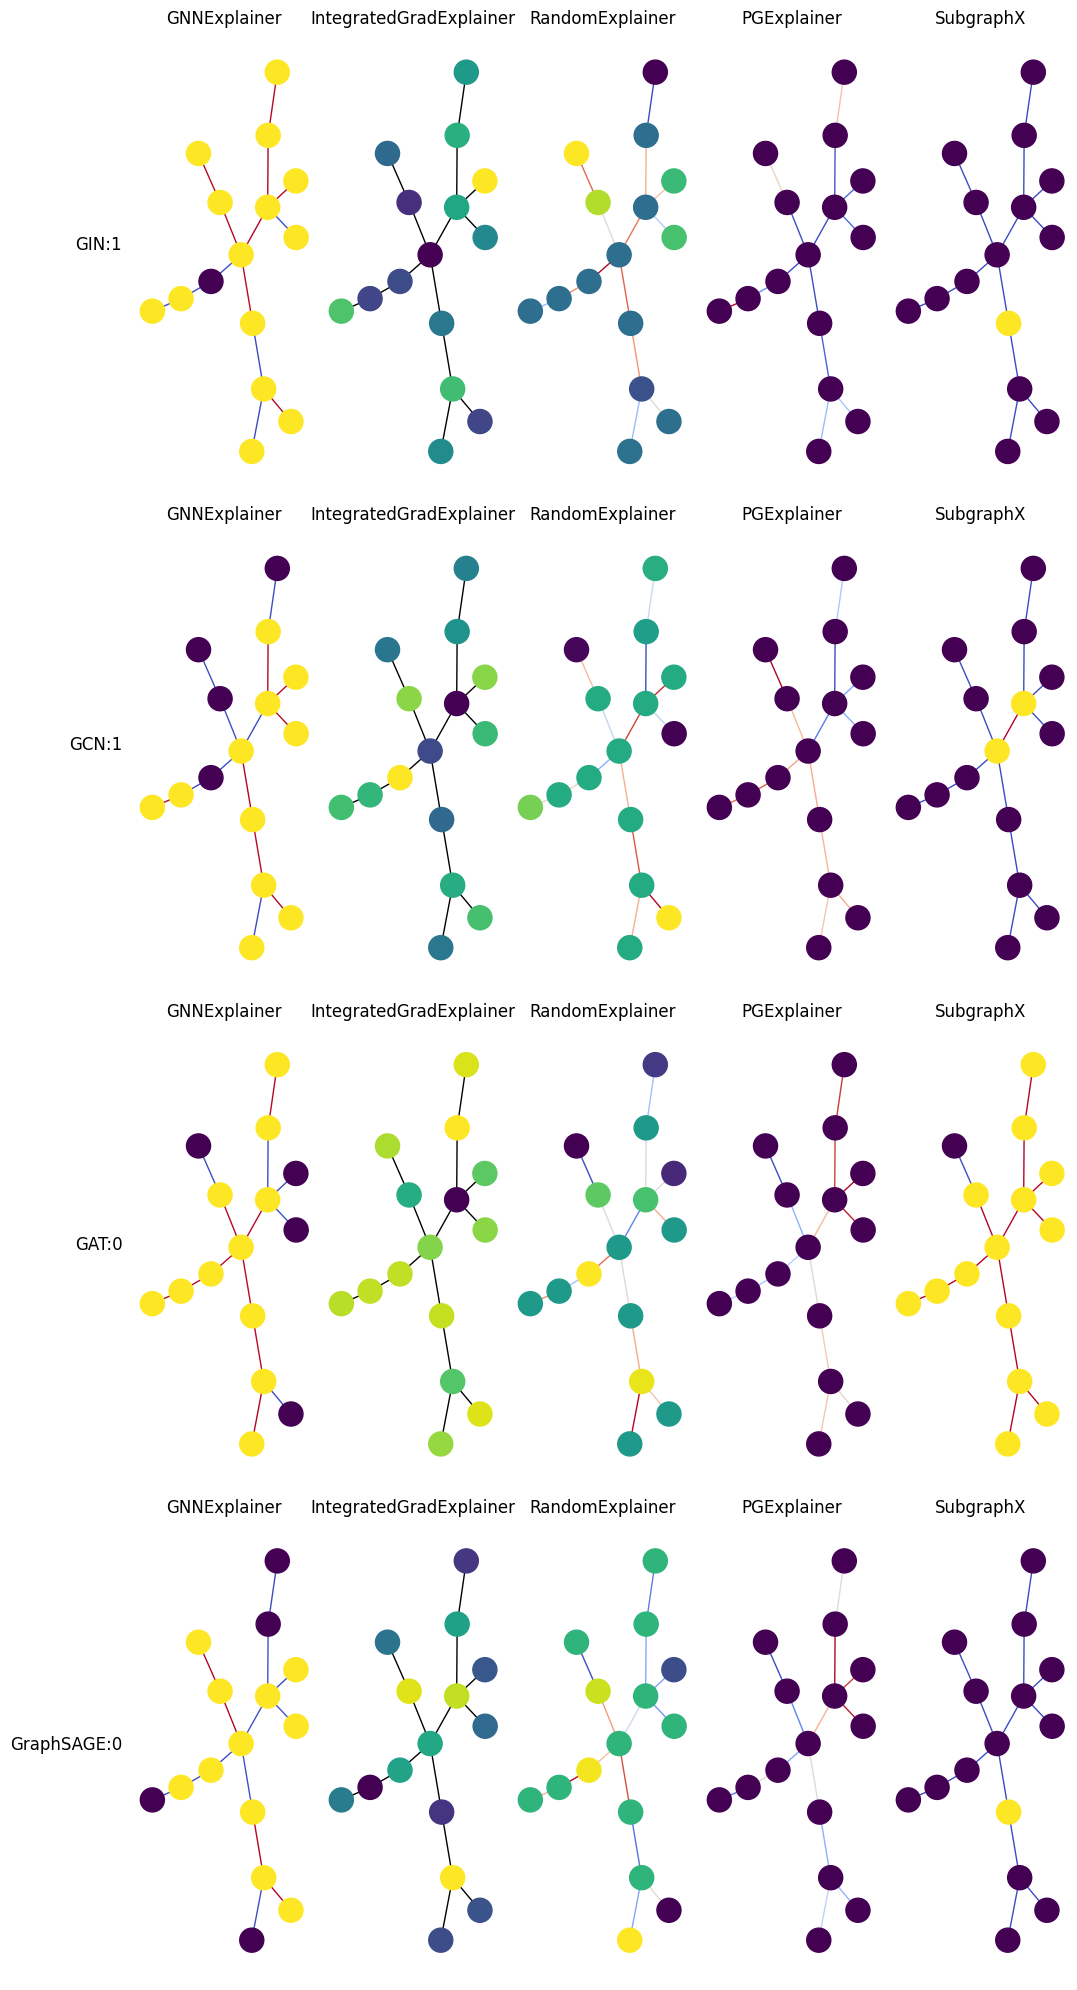

In [ ]:
import torch_geometric.utils as pyg_utils


fig, ax = plt.subplots(len(models), 5, figsize = (10, 20))

test_graph, explanation = dataset.get_test_w_label(1)
test_graph.to('cuda')
edge_index1 = pyg_utils.to_undirected(test_graph.edge_index)

for idx, (name, model) in enumerate(models.items()):

    pgex, gnnex, rndex, igex, subex = explainers[name].values()

    pg_exp = pgex.get_explanation_graph(x=test_graph.x, edge_index=edge_index1, label=test_graph.y, forward_kwargs = forward_kwargs)
    ig_exp = igex.get_explanation_graph(x = test_graph.x, edge_index = edge_index1, label=test_graph.y, forward_kwargs=forward_kwargs)
    rnd_ex = rndex.get_explanation_graph(x = test_graph.x, edge_index = edge_index1)
    gnn_exp = gnnex.get_explanation_graph(x = test_graph.x, edge_index = edge_index1)
    subex_exp = subex.get_explanation_graph(x=test_graph.x, edge_index=edge_index1, label=test_graph.y, forward_kwargs = forward_kwargs)
    
    ax[idx, 0].set_title('GNNExplainer')
    ax[idx, 1].set_title('IntegratedGradExplainer')
    ax[idx, 2].set_title('RandomExplainer')
    ax[idx, 3].set_title('PGExplainer')
    ax[idx, 4].set_title('SubgraphX')

    model.eval()
    out = model(test_graph.x, test_graph.edge_index)
    pred = out.argmax(dim=1).item()

    fig.text(0.04, (1 - (idx + 0.5) / len(models)), f"{name}:{pred}", va='center', ha='right', fontsize=12)

    gnn_exp.visualize_graph(ax = ax[idx, 0])
    ig_exp.visualize_graph(ax = ax[idx, 1])
    rnd_ex.visualize_graph(ax = ax[idx, 2])
    pg_exp.visualize_graph(ax = ax[idx, 3])
    subex_exp.visualize_graph(ax = ax[idx, 4])

plt.tight_layout(rect=[0.04, 0, 1, 1])
plt.show()

In [50]:
torch.cuda.empty_cache()

In [9]:
def fidelity(model, explanation, graph, device='cuda'):

    node_mask = explanation.node_imp.to(device)
    edge_mask = explanation.edge_imp.to(device) if explanation.edge_imp != None else None

    y = model(graph.x, graph.edge_index).softmax(dim=1)

    explain_y_hat = model(
        graph.x * node_mask.unsqueeze(-1) if node_mask is not None else graph.x,
        graph.edge_index[:, edge_mask.bool()] if edge_mask is not None else graph.edge_index
    ).softmax(dim=1)

    complement_y_hat = model(
        graph.x * (1 - node_mask).unsqueeze(-1) if node_mask is not None else graph.x,
        graph.edge_index[:, ~(edge_mask.bool())] if edge_mask is not None else graph.edge_index
    ).softmax(dim=1)

    pos_fidelity = 1.0 - (complement_y_hat == y).float().mean()
    neg_fidelity = 1.0 - (explain_y_hat == y).float().mean()

    return float(pos_fidelity), float(neg_fidelity)



def characterization_score( pos_fidelity, neg_fidelity, pos_weight=0.5, neg_weight=0.5):
    eps = 1e-9
    denom = (pos_weight / (pos_fidelity + eps)) + (neg_weight / (1. - neg_fidelity + eps))
    return 1. / denom

In [9]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"

import numpy as np
from graphxai.metrics.metrics_graph import graph_exp_acc_graph, graph_exp_faith_graph

graphs, explanations = dataset.get_data_list(dataset.test_index)

scores = {model_name:{explainer:{} for explainer in explainers[model_name]} for model_name in models}

for model_name in models:
    print()
    print(model_name)
    for exp_name, explainer in explainers[model_name].items():
        
        characterization = 0
        accuracy = np.zeros(3)
        faithfulness = np.zeros(3)

        num_graphs = 1000 if exp_name in ['PGExplainer'] else 10
        num_graphs = 5 if exp_name == "SubgraphX" else num_graphs

        for test_graph, explanation in zip(graphs[:num_graphs], explanations[:num_graphs]):
            

            if exp_name in ["GNNExplainer", "RandomExplainer"]:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index)
            else:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index, label=test_graph.y, forward_kwargs=forward_kwargs)

            # try:
            #     pos_fid, neg_fid = fidelity(models[model_name], gen_exp, test_graph)
            # except:
            #     continue
            
            # print(pos_fid, neg_fid)
            # characterization += characterization_score(pos_fid, neg_fid)
            
            acc_feat, acc_nodes, acc_edges = graph_exp_acc_graph(explanation, gen_exp)
            accuracy += [acc_feat if acc_feat != None else 0, acc_nodes, acc_edges if acc_edges else 0]

            faith_feat, faith_nodes, faith_edges = graph_exp_faith_graph(gen_exp, test_graph, models[model_name])
            faithfulness += [faith_feat if faith_feat != None else 0, faith_nodes, faith_edges if faith_edges else 0]

        # characterization /= num_graphs
        accuracy /= num_graphs
        faithfulness /= num_graphs
        
        # scores[model_name][exp_name]['characterization_score'] = characterization
        scores[model_name][exp_name]['accuracy'] = accuracy
        scores[model_name][exp_name]['faithfulness'] = faithfulness
        
        print('\t' + exp_name)
        # print('characterization_score:', characterization)
        print('accuracy:', accuracy)
        print('faithfulness:', faithfulness)



GIN
	PGExplainer
accuracy: [0.         0.01833176 0.01870093]
faithfulness: [0.         0.07692797 0.17084549]
	GNNExplainer
accuracy: [0.         0.01       0.00909091]
faithfulness: [0.         0.10498071 0.44836929]
	RandomExplainer
accuracy: [0.         0.         0.00909091]
faithfulness: [0.         0.14387826 0.44836929]
	IntegratedGradExplainer
accuracy: [0.         0.03333333 0.        ]
faithfulness: [0.         0.18066854 0.        ]
	SubgraphX
accuracy: [0. 0. 0.]
faithfulness: [0.         0.24006639 0.4582945 ]

GCN
	PGExplainer
accuracy: [0.         0.01833176 0.01870093]
faithfulness: [0.         0.06909466 0.20779396]
	GNNExplainer
accuracy: [0.         0.         0.00909091]
faithfulness: [0.         0.28768573 0.74432817]
	RandomExplainer
accuracy: [0.         0.         0.00909091]
faithfulness: [0.         0.12018623 0.74432818]
	IntegratedGradExplainer
accuracy: [0. 0. 0.]
faithfulness: [0.        0.0437061 0.       ]
	SubgraphX
accuracy: [0. 0. 0.]
faithfulness: 

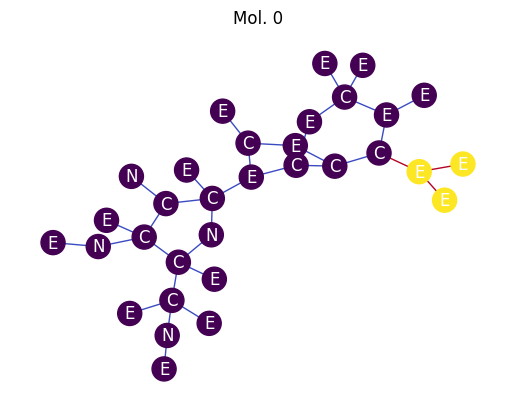

In [18]:
import networkx as nx

atom_map = {0: 'C', 1: 'N', 2: 'O'}

mutag = [dataset.get_test_w_label(1)]

for i in range(len(mutag)): #random.sample(list(range(len(mutag))), k = 5):
    g, exp = mutag[i]
    exp = exp[0]

    G, pos = exp.visualize_graph(show = False)
    #G = gxai_utils.to_networkx_conv(exp.graph, to_undirected=True)

    node_label = {}

    for j in range(exp.graph.x.shape[0]):
        ind = exp.graph.x[j,:].nonzero(as_tuple = True)[0].item()
        try:
            to_map = atom_map[ind]
        except KeyError:
            to_map = 'E'
        
        node_label[j] = to_map

    nx.draw_networkx_labels(G, pos, node_label, font_color = 'white')
    plt.title(f'Mol. {i}')
    plt.show()

In [50]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"


graphs, explanations = dataset.get_data_list(dataset.test_index)

for model_name in models:
    print()
    print(model_name)
    for name, explainer in explainers[model_name].items():
        if not name in ['IntegratedGradExplainer']:
            continue
        
        score = 0
        num_graphs = 1000 if name == "PGExplainer" else 100

        for test_graph, explanation in zip(graphs[:num_graphs], explanations[:num_graphs]):
            

            if name == "GNNExplainer":
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index)
            else:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index, label=test_graph.y, forward_kwargs=forward_kwargs)

            try:
                pos_fid, neg_fid = fidelity(models[model_name], gen_exp, test_graph)
            except:
                continue
            
            # print(pos_fid, neg_fid)
            score += characterization_score(pos_fid, neg_fid)
        print('\t' + name)
        print('characterization_score:', score / num_graphs)




GIN
	IntegratedGradExplainer
characterization_score: 1.9999999979999957e-09

GCN
	IntegratedGradExplainer
characterization_score: 1.5099999989399982e-09

GAT
	IntegratedGradExplainer
characterization_score: 1.9999999979999957e-09

GraphSAGE
	IntegratedGradExplainer
characterization_score: 1.6699999985799975e-09


In [38]:
scores

{'GIN': {'PGExplainer': {'characterization_score': 0.8866666677311125,
   'accuracy': array([0.        , 0.04831917, 0.04901899]),
   'faithfulness': array([0.        , 0.18974542, 0.39196862])},
  'GNNExplainer': {'characterization_score': 1.9999999980000002e-09,
   'accuracy': array([0., 0., 0.]),
   'faithfulness': array([0.        , 0.06091699, 0.44516159])},
  'IntegratedGradExplainer': {'characterization_score': 1.939999998119996e-09,
   'accuracy': array([0.        , 0.02739801, 0.        ]),
   'faithfulness': array([0.        , 0.07744902, 0.        ])},
  'SubgraphX': {'characterization_score': 1.9999999980000002e-09,
   'accuracy': array([0., 0., 0.]),
   'faithfulness': array([0.        , 0.0185726 , 0.07748699])}},
 'GCN': {'PGExplainer': {'characterization_score': 0.960000001020002,
   'accuracy': array([0.        , 0.04831917, 0.04901899]),
   'faithfulness': array([0.        , 0.16109991, 0.12877477])},
  'GNNExplainer': {'characterization_score': 1.9999999980000002e-09

In [11]:
import pandas as pd

methods = list(scores['GIN'].keys())
df_char = pd.DataFrame(index=scores.keys(), columns=methods)

for model in scores:
    for method in methods:
        df_char.loc[model, method] = scores[model][method]['characterization_score']

df_char

KeyError: 'characterization_score'

In [14]:
import pandas as pd
df_acc = pd.DataFrame()

methods = list(scores['GIN'].keys())

for model in scores:
    for method in methods:
        acc = scores[model][method]['accuracy']
        df_acc.loc[method, model] = str(tuple(map(lambda x: round(x, 4), acc[1:])))

# Сортировка столбцов по методам
# df_acc = df_acc.reindex(sorted(df_acc.columns, key=lambda x: x.split('_')[0]), axis=1)

df_acc

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.0183, 0.0187)","(0.0183, 0.0187)","(0.0183, 0.0187)","(0.0183, 0.0187)"
GNNExplainer,"(0.01, 0.0091)","(0.0, 0.0091)","(0.0, 0.0091)","(0.0, 0.0091)"
RandomExplainer,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
IntegratedGradExplainer,"(0.0333, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
SubgraphX,"(0.0, 0.0)","(0.0, 0.0)","(0.05, 0.0667)","(0.0, 0.0)"


In [33]:
tuple(np.random.random(2))

(0.6923318124530342, 0.21770412429618613)

In [13]:
for model in scores:
    scores[model]["RandomExplainer"]['accuracy'] = tuple(0*np.random.random(3))

In [15]:
import pandas as pd

df_faith = pd.DataFrame()

for model in scores:
    for method in methods:
        faith = scores[model][method]['faithfulness']
        df_faith.loc[method, model] = str(tuple(map(lambda x: round(x, 4), faith[1:])))

df_faith

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.0769, 0.1708)","(0.0691, 0.2078)","(0.0341, 0.2243)","(0.079, 0.1962)"
GNNExplainer,"(0.105, 0.4484)","(0.2877, 0.7443)","(0.0832, 0.8507)","(0.2427, 0.6846)"
RandomExplainer,"(0.1439, 0.4484)","(0.1202, 0.7443)","(0.0747, 0.8507)","(0.2863, 0.6846)"
IntegratedGradExplainer,"(0.1807, 0.0)","(0.0437, 0.0)","(0.0689, 0.0)","(0.1013, 0.0)"
SubgraphX,"(0.2401, 0.4583)","(0.1851, 0.7298)","(0.2176, 0.8508)","(0.28, 0.6536)"


In [39]:
import pandas as pd

df_faith = pd.DataFrame()

for model in scores:
    for method in methods:
        faith = scores[model][method]['faithfulness']
        df_faith.loc[method, model] = str(tuple(map(lambda x: round(x, 4), faith[1:])))

df_faith

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.1736, 0.1995)","(0.0452, 0.0806)","(0.0428, 0.1946)","(0.0502, 0.1309)"
GNNExplainer,"(0.5101, 0.6432)","(0.1278, 0.2226)","(0.1232, 0.7531)","(0.2055, 0.4264)"
RandomExplainer,"(0.1858, 0.2543)","(0.17, 0.2112)","(0.0302, 0.1268)","(0.0394, 0.1775)"
IntegratedGradExplainer,"(0.1052, 0.0)","(0.0398, 0.0)","(0.0638, 0.0)","(0.0645, 0.0)"
SubgraphX,"(0.4617, 0.4183)","(0.0633, 0.1329)","(0.2179, 0.7373)","(0.0802, 0.3757)"
